# GoogLeNet 卷积神经网络

本示例为 GoogLeNet 模型系列的第一个版本，用 MXNet 实现，完成 Fashion-MNIST 图像分类任务。

GoogLeNet 吸收了 NiN 中网络串联网络的思想，并在此基础上做了很大改进。

GoogLeNet中的基础卷积块叫作 Inception 块。Inception块的结构：

![image.png](img/cnn_goodlenet_1.png)

In [0]:
import os
import sys
import time

import mxnet as mx
from mxnet import gluon, init, autograd, nd
from mxnet.gluon import data as gdata
from mxnet.gluon import loss as gloss, nn

## 读取数据

In [0]:
def load_data_fashion_mnist(batch_size, resize=None, root=os.path.join(
        '~', '.mxnet', 'datasets', 'fashion-mnist')):
    root = os.path.expanduser(root)  # 展开用户路径'~'
    transformer = []
    if resize:
        transformer += [gdata.vision.transforms.Resize(resize)]
    transformer += [gdata.vision.transforms.ToTensor()]
    transformer = gdata.vision.transforms.Compose(transformer)
    mnist_train = gdata.vision.FashionMNIST(root=root, train=True)
    mnist_test = gdata.vision.FashionMNIST(root=root, train=False)
    num_workers = 0 if sys.platform.startswith('win32') else 4
    train_iter = gdata.DataLoader(
        mnist_train.transform_first(transformer), batch_size, shuffle=True,
        num_workers=num_workers)
    test_iter = gdata.DataLoader(
        mnist_test.transform_first(transformer), batch_size, shuffle=False,
        num_workers=num_workers)
    return train_iter, test_iter

In [4]:
batch_size = 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)

## 定义模型

先定义 Inception 块。

Inception 块里有 4 条并行的线路。前 3 条线路使用窗口大小分别是 1×1 、 3×3 和 5×5 的卷积层来抽取不同空间尺寸下的信息，其中中间 2 个线路会对输入先做 1×1 卷积来减少输入通道数，以降低模型复杂度。第四条线路则使用 3×3 最大池化层，后接 1×1 卷积层来改变通道数。4 条线路都使用了合适的填充来使输入与输出的高和宽一致。最后我们将每条线路的输出在通道维上连结，并输入接下来的层中去。

In [0]:
# 定义 Inception 块
class Inception(nn.Block):
    # c1 - c4 为每条线路里的层的输出通道数
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1 x 1卷积层
        self.p1_1 = nn.Conv2D(c1, kernel_size=1, activation='relu')
        # 线路2，1 x 1卷积层后接3 x 3卷积层
        self.p2_1 = nn.Conv2D(c2[0], kernel_size=1, activation='relu')
        self.p2_2 = nn.Conv2D(c2[1], kernel_size=3, padding=1,
                              activation='relu')
        # 线路3，1 x 1卷积层后接5 x 5卷积层
        self.p3_1 = nn.Conv2D(c3[0], kernel_size=1, activation='relu')
        self.p3_2 = nn.Conv2D(c3[1], kernel_size=5, padding=2,
                              activation='relu')
        # 线路4，3 x 3最大池化层后接1 x 1卷积层
        self.p4_1 = nn.MaxPool2D(pool_size=3, strides=1, padding=1)
        self.p4_2 = nn.Conv2D(c4, kernel_size=1, activation='relu')

    def forward(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        return nd.concat(p1, p2, p3, p4, dim=1)  # 在通道维上连结输出

GoogLeNet 跟 VGG 一样，在主体卷积部分中使用 5 个模块（block），每个模块之间使用步幅为 2 的 3×3 最大池化层来减小输出高宽。

第一模块使用一个 64 通道的 7×7 卷积层。

In [0]:
b1 = nn.Sequential()
b1.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3, activation='relu'),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

第二模块使用 2 个卷积层：首先是 64 通道的 1×1 卷积层，然后是将通道增大3倍的 3×3 卷积层。它对应 Inception 块中的第二条线路。

In [0]:
b2 = nn.Sequential()
b2.add(nn.Conv2D(64, kernel_size=1, activation='relu'),
       nn.Conv2D(192, kernel_size=3, padding=1, activation='relu'),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

第三模块串联 2 个完整的 Inception 块。

第一个 Inception 块的输出通道数为 64+128+32+32=256 ，其中4条线路的输出通道数比例为 64:128:32:32=2:4:1:1 。其中第二、第三条线路先分别将输入通道数减小至 96/192=1/2 和 16/192=1/12 后，再接上第二层卷积层。

第二个Inception块输出通道数增至 128+192+96+64=480 ，每条线路的输出通道数之比为 128:192:96:64=4:6:3:2 。其中第二、第三条线路先分别将输入通道数减小至 128/256=1/2 和 32/256=1/8 。

In [0]:
b3 = nn.Sequential()
b3.add(Inception(64, (96, 128), (16, 32), 32),
       Inception(128, (128, 192), (32, 96), 64),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

第四模块更加复杂。它串联了5个Inception块，其输出通道数分别是 192+208+48+64=512 、 160+224+64+64=512 、 128+256+64+64=512 、 112+288+64+64=528 和 256+320+128+128=832 。这些线路的通道数分配和第三模块中的类似，首先含 3×3 卷积层的第二条线路输出最多通道，其次是仅含 1×1 卷积层的第一条线路，之后是含 5×5 卷积层的第三条线路和含 3×3 最大池化层的第四条线路。其中第二、第三条线路都会先按比例减小通道数。这些比例在各个Inception块中都略有不同。

In [0]:
b4 = nn.Sequential()
b4.add(Inception(192, (96, 208), (16, 48), 64),
       Inception(160, (112, 224), (24, 64), 64),
       Inception(128, (128, 256), (24, 64), 64),
       Inception(112, (144, 288), (32, 64), 64),
       Inception(256, (160, 320), (32, 128), 128),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

第五模块有输出通道数为 256+320+128+128=832 和 384+384+128+128=1024 的两个Inception块。

其中每条线路的通道数的分配思路和第三、第四模块中的一致，只是在具体数值上有所不同。需要注意的是，第五模块的后面紧跟输出层，该模块同 NiN 一样使用全局平均池化层来将每个通道的高和宽变成1。

In [0]:
b5 = nn.Sequential()
b5.add(Inception(256, (160, 320), (32, 128), 128),
       Inception(384, (192, 384), (48, 128), 128),
       nn.GlobalAvgPool2D())

最后我们将输出变成二维数组后接上一个输出个数为标签类别数的全连接层。

In [0]:
net = nn.Sequential()
# 连接五个模块和最后的全连接层
net.add(b1, b2, b3, b4, b5, nn.Dense(10))

## 模型训练

In [0]:
# 尝试在gpu(0)上创建NDArray，如果成功则使用gpu(0)，否则仍然使用CPU
def try_gpu(): 
    try:
        ctx = mx.gpu()
        _ = nd.zeros((1,), ctx=ctx)
    except mx.base.MXNetError:
        ctx = mx.cpu()
    return ctx

def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()

def evaluate_accuracy(data_iter, net, ctx):
    acc_sum, n = nd.array([0], ctx=ctx), 0
    for X, y in data_iter:
        # 如果ctx代表GPU及相应的显存，将数据复制到显存上
        X, y = X.as_in_context(ctx), y.as_in_context(ctx).astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.size
    return acc_sum.asscalar() / n

In [0]:
def train(net, train_iter, test_iter, batch_size, trainer, ctx, num_epochs):
    print('training on', ctx)
    loss = gloss.SoftmaxCrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X, y = X.as_in_context(ctx), y.as_in_context(ctx)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net, ctx)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [14]:
lr, num_epochs, ctx = 0.1, 5, try_gpu()

net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
train(net, train_iter, test_iter, batch_size, trainer, ctx, num_epochs)

training on gpu(0)
epoch 1, loss 2.2613, train acc 0.153, test acc 0.304, time 56.5 sec
epoch 2, loss 1.0973, train acc 0.559, test acc 0.727, time 53.6 sec
epoch 3, loss 0.5818, train acc 0.782, test acc 0.837, time 53.3 sec
epoch 4, loss 0.4449, train acc 0.834, test acc 0.860, time 53.6 sec
epoch 5, loss 0.3782, train acc 0.858, test acc 0.871, time 53.5 sec


## 模型预测

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# 将数值标签转成相应的文本标签。
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

# 在一行里画出多张图像和对应标签
def show_fashion_mnist(images, labels):
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape((96, 96)).asnumpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

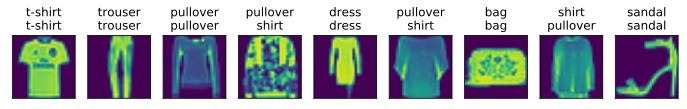

In [16]:
for X, y in test_iter:
    break
X, y = X.as_in_context(ctx), y.as_in_context(ctx)

true_labels = get_fashion_mnist_labels(y.asnumpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())

titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

show_fashion_mnist(X[0:9], titles[0:9])